In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage import shift, zoom

In [7]:
import ants

In [35]:
affine = np.load("../affine5.npy")
warped = np.load("../warped5.npy")

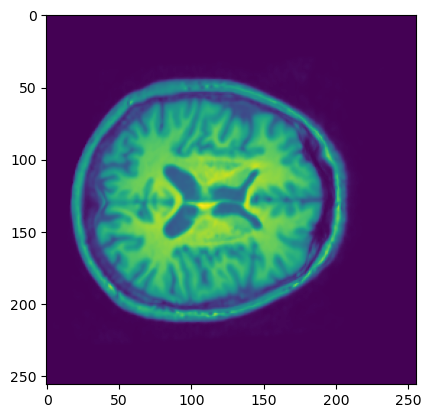

In [34]:
plt.imshow(warped)

In [17]:
t2_path = r'../UTF-8IXI516-HH-2297-DE3Diso_-s3T223_-0401-00004-000002-02.nii'
t1_path = r'../UTF-8IXI516-HH-2297-MADisoTFE1_-s3T223_-0301-00003-000001-01.nii'

img_t2 = ants.image_read(t2_path)
img_t1 = ants.image_read(t1_path)

t2_img = nib.load(t2_path)
t1_img = nib.load(t1_path)

t2_data = t2_img.get_fdata()
t1_data = t1_img.get_fdata()

#Code to obtain the corresponding slices since the slicing indexes arnt the same

t2_slice_idx = 70
t2_aff = t2_img.affine
t1_aff = t1_img.affine


t2_voxel = np.array([t2_data.shape[0]//2, t2_data.shape[1]//2, t2_slice_idx, 1])
t2_world = t2_aff @ t2_voxel  # Gives (x, y, z, 1)
t2_z_mm = t2_world[2]


t1_voxel = np.linalg.inv(t1_aff) @ t2_world
t1_slice_idx = int(round(t1_voxel[1])) 

def ants_rot90(antsimage, rot):
    # Extract the array representation
    image_array = antsimage.numpy()
    
    new_array = np.rot90(image_array, rot)
    
    # Create a new ANTs image from the manipulated array with the original metadata
    newantsimage = ants.from_numpy(new_array, origin=antsimage.origin, 
                                spacing=antsimage.spacing, direction=antsimage.direction)
    return newantsimage

fixed_image = img_t2[:,:,t2_slice_idx]
image_to_register = img_t1[:,t1_slice_idx,:]

# Rotate by -90 degrees to give the registration a good place to start
image_to_register = ants_rot90(image_to_register, -1)

In [9]:
def crop_overlap(image_A, image_B): 
    h = min(image_A.shape[0], image_B.shape[0])
    w = min(image_A.shape[1], image_B.shape[1]) 
    return image_A[:h, :w], image_B[:h,:w]
def joint_histogram(image_A, image_B, bins = 64): 

    A_samples = image_A.flatten() #Flatten to then treat the voxels as samples from the random variable (the image)
    B_samples = image_B.flatten()

    joint_hist, A_boundary, B_boundary = np.histogram2d(A_samples, B_samples, bins = bins) 
    #Creating joint histogram from joint probablity of Image A and Image B. A and Boundaries are variables that store intensity value in thesholds from A and B samples.

    return joint_hist
def normalize_histogram(hist): 
    x = hist / np.sum(hist) 
    return x


In [36]:
#shift_t1 = shift(t1_scaled, shift = (dy, dx), mode = 'nearest')

image_A_crop, image_B_crop = affine, fixed_image

joint_hist = joint_histogram(image_A_crop, image_B_crop, bins = 64)
joint_prob = normalize_histogram(joint_hist) 
ProbA = np.sum(joint_prob, axis = 1)  #summing across rows to get probability of A
ProbB = np.sum(joint_prob, axis = 0) #summing across columns to get probability of B
eps = 1e-10
H_A = -np.sum(ProbA * np.log(ProbA + eps)) #Computing entropy H(A) (Equation given from class)
H_B = -np.sum(ProbB * np.log(ProbB + eps)) #Computing entropy H(B) 
ProbA_GivenB = joint_prob / (ProbB[np.newaxis, :] + eps) #Using conditional probality equation. np.newaxis is used to make ProbB a row vector (shape match) 
H_A_GivenBm = -np.sum(ProbA_GivenB * np.log(ProbA_GivenB + eps), axis = 0) #summing over rows (where A_boundary is)
H_A_GivenB = np.sum(ProbB * H_A_GivenBm)
MI = H_A - H_A_GivenB

In [37]:
MI

0.6691832022825894